In [1]:
import os, sys, rdflib
from sklearn import metrics
import numpy as np, pandas as pd
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from SPARQLWrapper import SPARQLWrapper, JSON
import rdflib.plugins.sparql as sparql, matplotlib.pyplot as plt
sys.path.append(os.path.abspath("./util"))
from misc import *

plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [2]:
%%time
%store -r mid2types
if "mid2types" not in locals():
    dbpedia_type_graph = rdflib.Graph()
    dbpedia_type_graph.parse('./dataset/instance_types_en_uris_it.nt', format="nt" )
    dbpedia_type_graph.parse('./dataset/instance_types_en.nt', format="nt" )

CPU times: user 38.7 ms, sys: 10.7 ms, total: 49.4 ms
Wall time: 95.6 ms


In [3]:
%%time
# mapping freebase's mids to dbpedia's resources
mid2dbpedia = dict()
file_path = "./dataset/Release/freebase_code_names.txt"
with open(file_path, "r") as mapping_file:
    for line in mapping_file:
        mid, dbp_resource = line.replace("\n", "").split("\t")
        val = mid2dbpedia.get(mid, [])
        mid2dbpedia[mid] = val + [dbp_resource]

CPU times: user 283 ms, sys: 12.2 ms, total: 295 ms
Wall time: 335 ms


In [4]:
walks_path = "./dataset/Release/ttl/embedding_5_7_train.ttl.txt"

vocab_sequences = get_sequences(walks_path)
train_sequences = get_sequences(walks_path)

model = Word2Vec(min_count=1, window=5, negative=5, size=100)

model.build_vocab(vocab_sequences)
model.train(train_sequences)

418031

In [5]:
%%time
%store -r mid2types
if "mid2types" not in locals():
    mid2types = dict()
    for uri in model.vocab:
        mid = uri.replace("http://rdf.freebase.com/ns", "")
        if mid in mid2dbpedia:
            dbpedia_eqs = [uri[1:-1] for uri in mid2dbpedia[mid]]
            mid_types = {row[0].n3() for uri in dbpedia_eqs for row in get_types(uri, dbpedia_type_graph)}
            if len(mid_types) > 0:
                mid2types[mid] = mid_types
    %store mid2types

CPU times: user 385 µs, sys: 188 µs, total: 573 µs
Wall time: 412 µs


In [6]:
mid_prefix = "http://rdf.freebase.com/ns"

embeds = np.asarray([model[mid_prefix + mid] for mid in mid2types])
mids   = np.asarray([mid for mid in mid2types])
labels = get_ground_truth(mids, mid2types) # np.asarray([1 if is_person(mid, mid2types) else 0 for mid in mid2types])

random_idx = np.random.choice(range(len(embeds)), len(embeds), replace=False)
split_point = len(embeds) * 70 / 100
training_idx, test_idx = random_idx[:split_point], random_idx[split_point:]

embeds_train, embeds_test = embeds[training_idx], embeds[test_idx]
mids_train,   mids_test   = mids[training_idx],   mids[test_idx]
labels_train, labels_test = labels[training_idx], labels[test_idx]

tsne = TSNE(n_components=2)
%store -r twodims
if "twodims" not in locals():
    twodims = tsne.fit_transform(embeds)
    %store twodims

# ground_truth = get_ground_truth(mids, mid2types)
colors = [get_color(i) for i in labels]

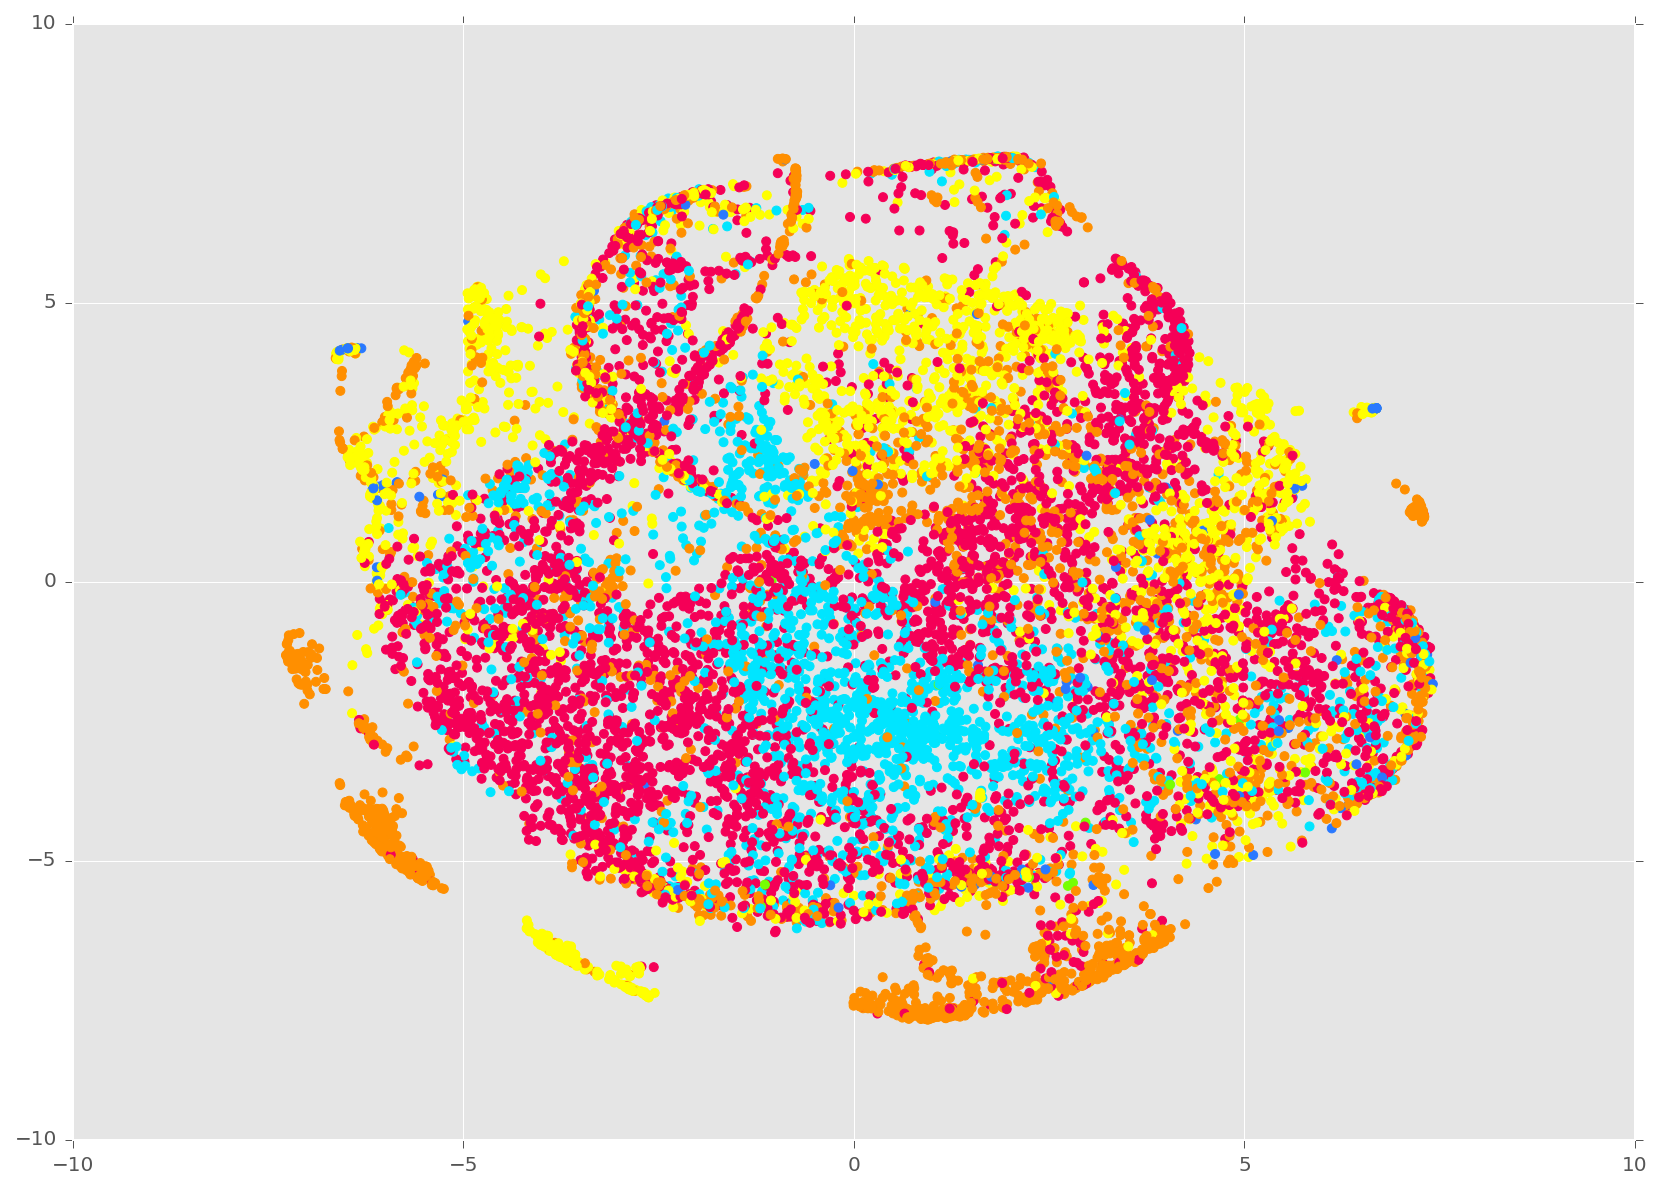

In [7]:
plt.rcParams["figure.figsize"] = [14, 10]
x = [point[0] for point in twodims]
y = [point[1] for point in twodims]
plt.scatter(x, y, color=colors)
plt.show()

In [8]:
%%time
ovo_rbf    = OneVsOneClassifier(SVC(gamma=2, C=1))
ovo_forest = OneVsOneClassifier(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1))
ovr_rbf    = OneVsRestClassifier(SVC(gamma=2, C=1))
ovr_forest = OneVsRestClassifier(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1))

ovo_rbf.fit(embeds_train, labels_train)
ovo_forest.fit(embeds_train, labels_train)
ovr_rbf.fit(embeds_train, labels_train)
ovr_forest.fit(embeds_train, labels_train)

ovo_rbf_pred    = np.array([ovo_rbf.predict([emb]) for emb in embeds_test])
ovo_forest_pred = np.array([ovo_forest.predict([emb]) for emb in embeds_test])
ovr_rbf_pred    = np.array([ovr_rbf.predict([emb]) for emb in embeds_test])
ovr_forest_pred = np.array([ovr_forest.predict([emb]) for emb in embeds_test])

CPU times: user 1min 45s, sys: 243 ms, total: 1min 45s
Wall time: 1min 45s


Confusion matrix, without normalization


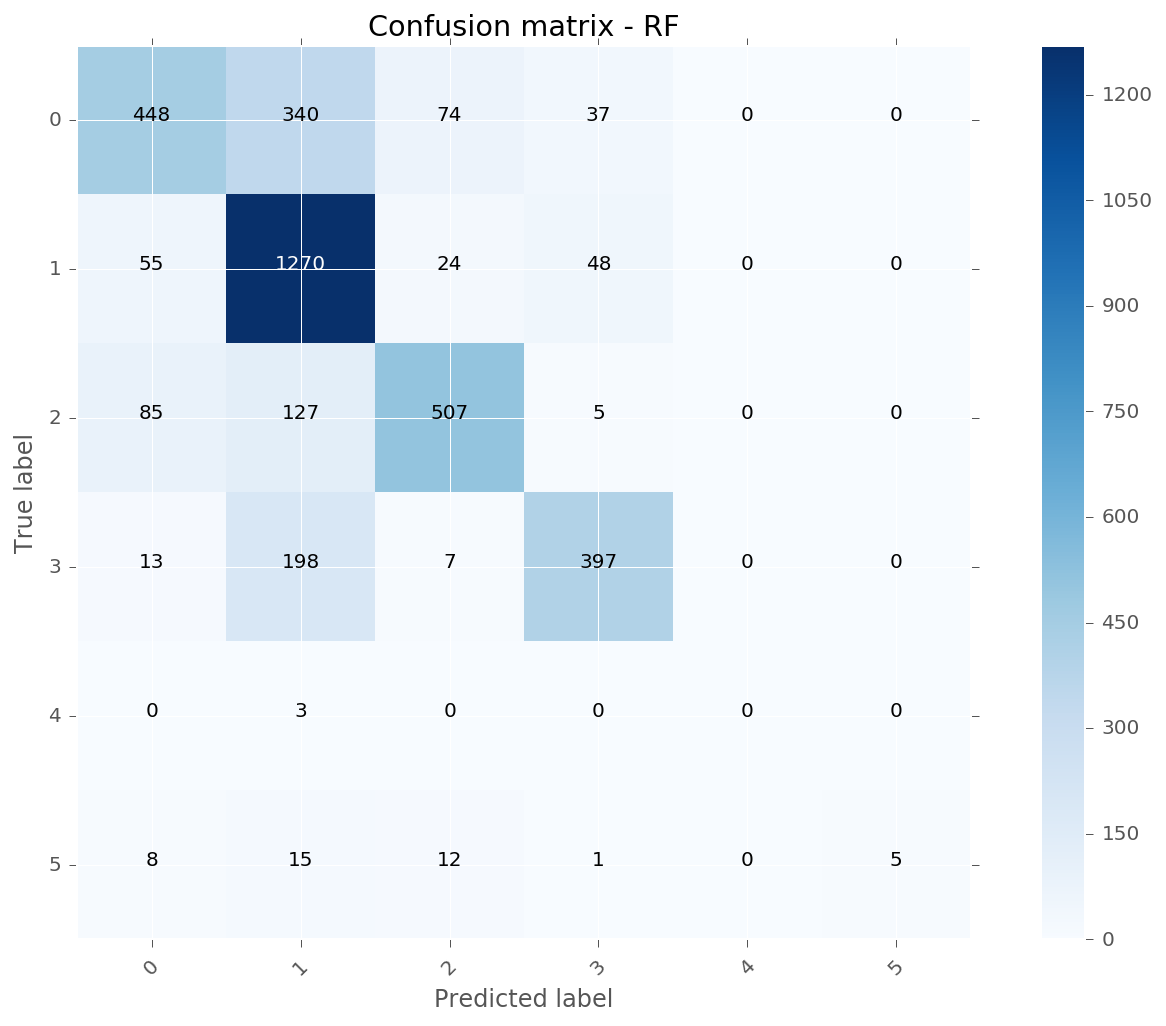

In [9]:
plt.rcParams["figure.figsize"] = [10, 7]

cnf_matrix = metrics.confusion_matrix(labels_test, ovo_rbf_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5], title='Confusion matrix - RF')
plt.show()

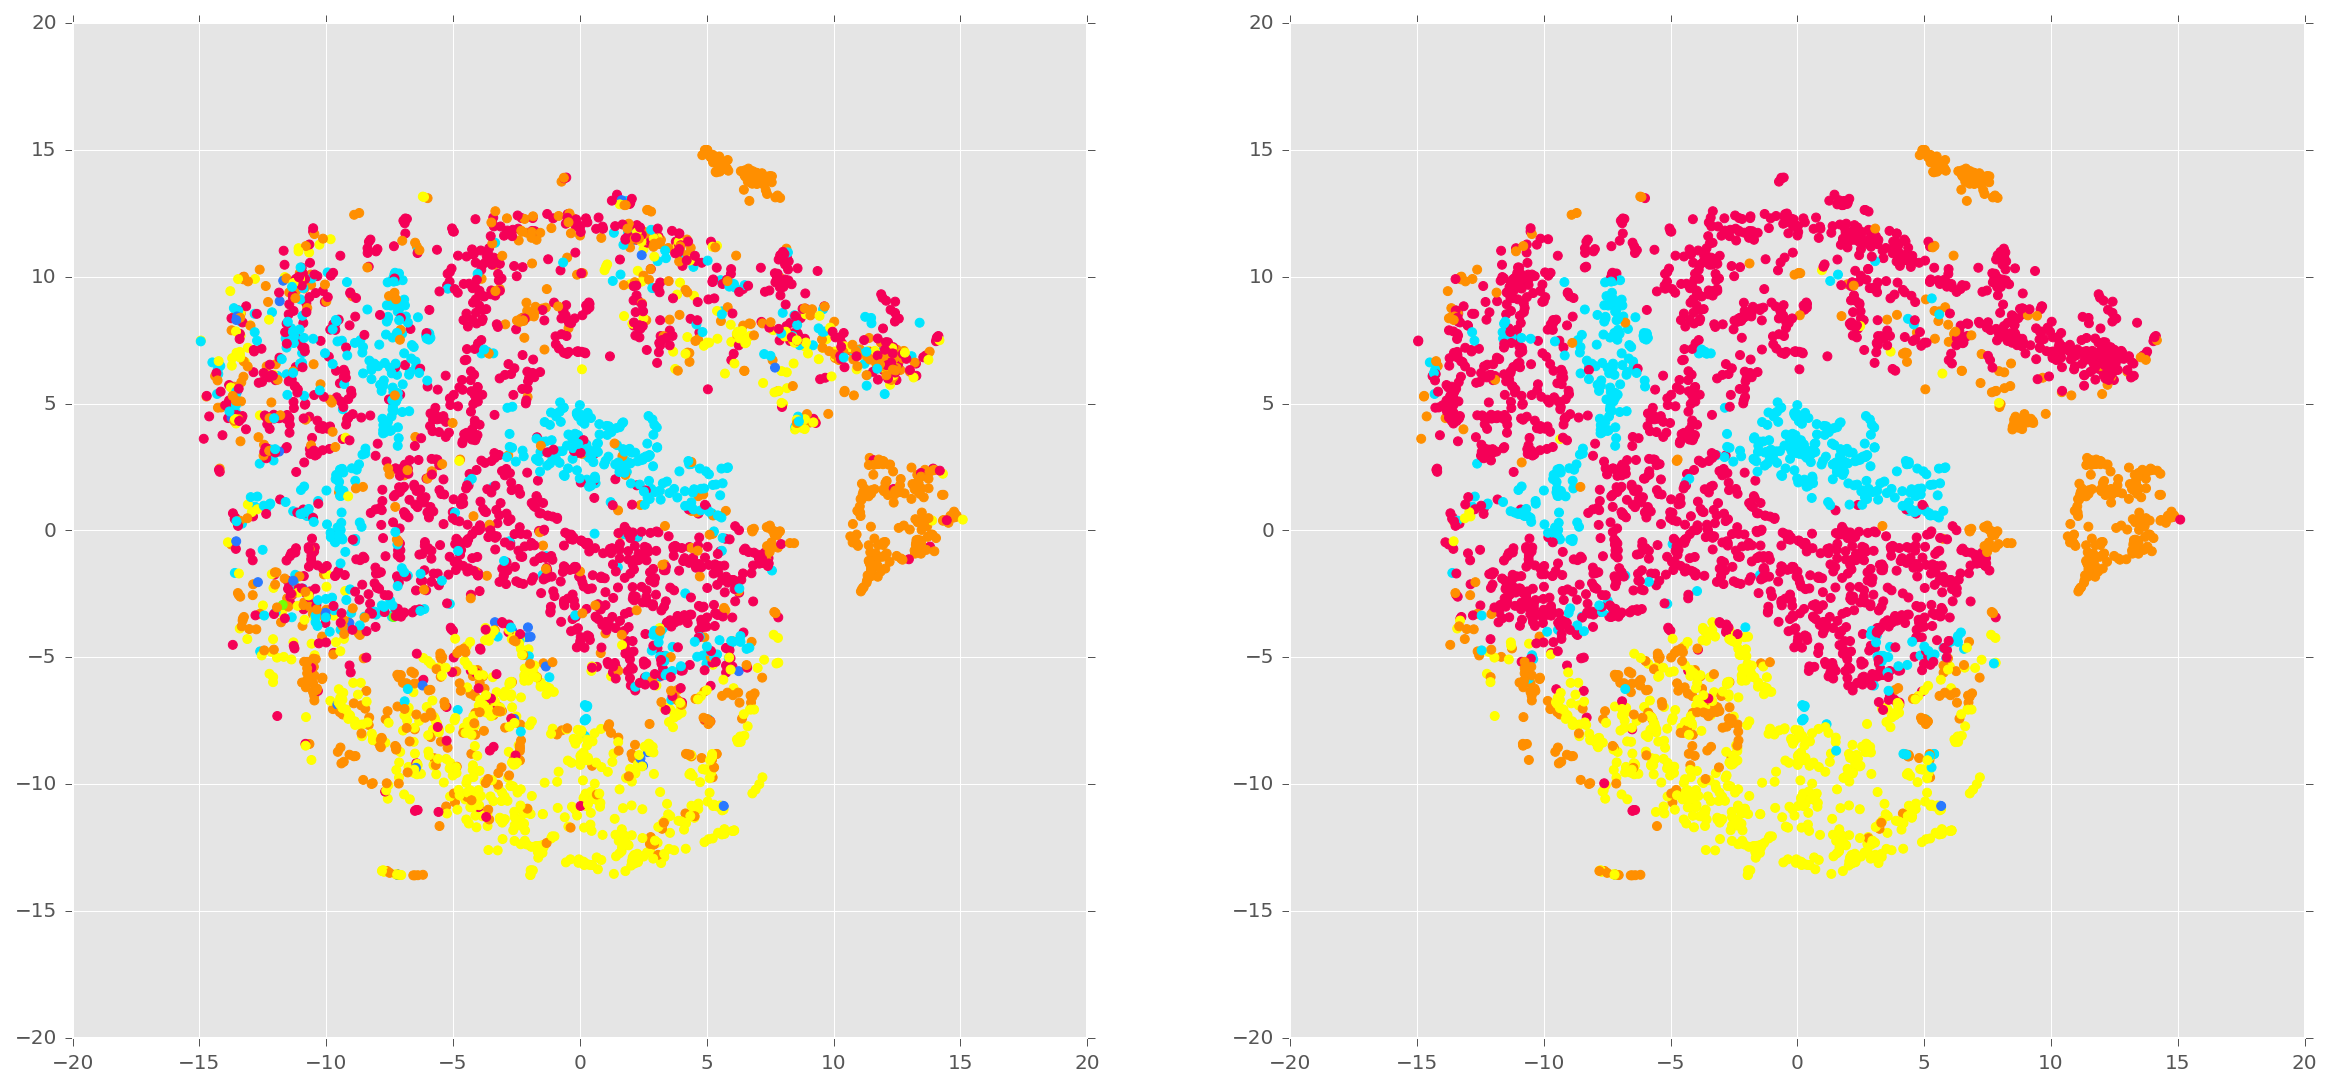

In [10]:
twodims_test = tsne.fit_transform(embeds_test)
colors_true = [get_color(i) for i in labels_test]
colors_pred = [get_color(i) for i in ovo_rbf_pred]

plt.rcParams["figure.figsize"] = [20, 20]
fig, ax = plt.subplots(nrows=1,ncols=2)
x_test = [point[0] for point in twodims_test]
y_test = [point[1] for point in twodims_test]

plt.subplot(2, 2, 1)
plt.scatter(x_test, y_test, color=colors_true)

plt.subplot(2, 2, 2)
plt.scatter(x_test, y_test, color=colors_pred)
plt.show()

In [13]:
metrics_class_df = pd.concat([
    multiclass_metrics(labels_test, ovo_rbf_pred, average="weighted", name="OnevOne RBF SVM"),
    multiclass_metrics(labels_test, ovo_forest_pred, average="weighted", name="OnevOne Forest"),
    multiclass_metrics(labels_test, ovr_rbf_pred, average="weighted", name="OnevRest RBF SVM"),
    multiclass_metrics(labels_test, ovr_forest_pred, average="weighted", name="OnevRest Forest")
])

metrics_class_df

,Accuracy,Kappa,Precision,Recall,F1-score
OnevOne RBF SVM,0.714053,0.592904,0.733717,0.714053,0.703889
OnevOne Forest,0.668660,0.525398,0.688734,0.668660,0.653022
OnevRest RBF SVM,0.736613,0.631140,0.747597,0.736613,0.724743
OnevRest Forest,0.653710,0.500355,0.684843,0.653710,0.632705
